In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities_visualization
from process_movella import load_movella, get_position
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration

# Load Data

In [2]:
IN_DIRS = [
    Path("uploads/2025-09-03 Experiment 5/2025-09-03 Quaternions"),
    Path("uploads/2025-09-03 Experiment 5/2025-09-03 Euler Angles"),
    ]

In [3]:
# Reading sensor data
sensor_ids = ['OR','OL','IB','IT','IL']
quantities = ['time','ax','ay','az','phi','theta','psi','wx','wy','wz']
sensors = {
    'OR': 'hoop',
    'OL': 'hip',
    'IB': 'femur',
    'IT': 'tibia',
    'IL': 'cuneiform'
}

test_file_paths = sorted(list(IN_DIRS[0].glob("OR_*.csv")))
n_recordings = len(test_file_paths)
for i in range(n_recordings):
    data_shapes = np.zeros((2,5,2))
    for j,in_dir in enumerate(IN_DIRS):
        files = {
            sid : sorted(list(in_dir.glob(f"{sid}_*.csv")))[i]
            for sid in sensor_ids
        }
        raw_data = {
            sid: load_movella(files[sid], lead_time=0)
            for sid in sensor_ids
        }
        
        data_shapes[j] = [d.shape for d in raw_data.values()]
        
        raw_data_dict = {}

        for sid in sensor_ids:
            array = raw_data[sid]
            raw_data_dict[sid] = {q: array[:,i] for i,q in enumerate(quantities)}
            raw_data_dict[sid]['amag'] = np.sqrt(raw_data_dict[sid]['ax']**2 + raw_data_dict[sid]['ay']**2)

        # time step
        dt = raw_data_dict['OR']['time'][1]-raw_data_dict['OR']['time'][0]

        # show a table of the data
        # print("Raw Data; Local Axes")
        # pd.DataFrame(raw_data_dict)
    assert all(data_shapes[j][k][l] == data_shapes[j][0][l] for k in range(5) for l in range(2)), f"{data_shapes=}, {test_file_paths[i]=}"


In [4]:
data = np.vstack([raw_data_dict[sensor_id][quantity]
                        for sensor_id in sensor_ids
                        for quantity in quantities[1:]])
print(f"{data.shape=}")
# np.save("data_experiment_test.npy", data)

data.shape=(45, 3042)


# Raw Data in the local axes

In [5]:
sensor_titles = [sensors[sid] for sid in sensor_ids]
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'psi': 'rgba(0, 0, 255, 0.7)','theta': 'rgba(255, 0, 0, 0.7)','phi': 'rgba(0, 128, 0, 0.7)'}
legend_shown = {'psi': False, 'theta': False, 'phi': False}

for i,sid in enumerate(sensor_ids, start=1):
    for angle_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][angle_type], 
            mode='lines', 
            name=angle_type,
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Euler Angle Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [6]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'ax': 'rgba(0, 0, 255, 0.7)','ay': 'rgba(255, 0, 0, 0.7)','az': 'rgba(0, 128, 0, 0.7)', 'amag': 'rgba(128, 0, 128, 0.8)'}
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

# Steady Hooping Interval

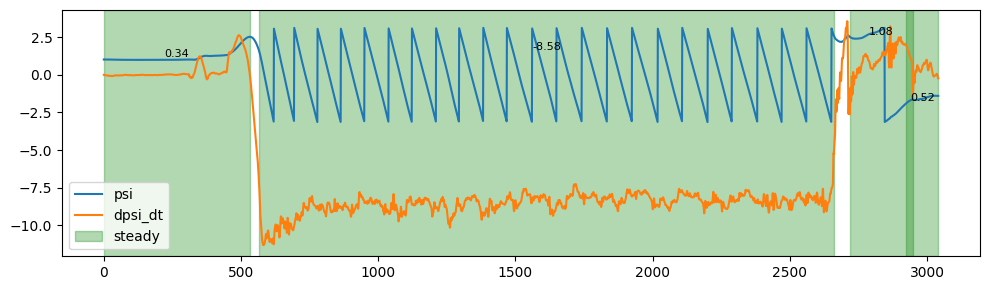

In [7]:
OR_groups, OR_averages = get_steady_hooping_interval(raw_data_dict['OR']['psi'], dt=dt, threshold=0.8)
t_active = OR_groups[1]
active_slice = slice(*t_active)

# Fixed Frame Data

In [8]:
fixed_data_dict = {}
accels = ['ax','ay','az']
for sid in sensor_ids:
    fixed_a = get_fixed_frame_acceleration(raw_data_dict[sid]['ax'], raw_data_dict[sid]['ay'], raw_data_dict[sid]['az'],
                                           raw_data_dict[sid]['psi'], raw_data_dict[sid]['theta'], raw_data_dict[sid]['phi'])
    fixed_data_dict[sid] = {a:fixed_a[i] for i,a in enumerate(accels)}
    fixed_data_dict[sid]['amag'] = np.sqrt(fixed_data_dict[sid]['ax']**2 + fixed_data_dict[sid]['ay']**2)

In [9]:
positions_velocities = ['dx','dy','dz','vx','vy','vz']
for sid in sensor_ids:
    array = get_position(raw_data_dict[sid]['time'],fixed_data_dict[sid]['ax'],fixed_data_dict[sid]['ay'],fixed_data_dict[sid]['az'],
                         degree=20,initial=0)
    for i,pv in enumerate(positions_velocities):
        fixed_data_dict[sid][pv] = array[i]

print("Fixed Frame Data")
pd.DataFrame(fixed_data_dict)

Fixed Frame Data


,OR,OL,IB,IT,IL
ax,"[-0.26872530856175664, -0.11333454225964172, 0...","[-0.09783254939440579, -0.11953894047307087, -...","[-0.10655123506264065, -0.09706688835521682, -...","[-0.05425833858080203, -0.030236245947100206, ...","[-0.01146138886909304, 0.040231172822843685, 0..."
ay,"[0.19169888926721979, 0.06711478233238045, -0....","[-0.042989198637288034, 0.024659894451172122, ...","[-0.03338046407877419, -0.014936290395949355, ...","[0.031320178872775724, 0.0618216707191623, 0.0...","[-0.013842749847575215, -0.012722619035797505,..."
az,"[-0.2061760584892826, -0.3642460809284159, -0....","[0.0394209617502787, -0.10065286391797339, -0....","[0.04510130480145643, 0.00043807910167145, 0.0...","[-0.007609400715223431, 0.02163226238816142, 0...","[0.034312393546365054, 0.016817674294177992, -..."
amag,"[0.3300935558412147, 0.13171602968783003, 0.02...","[0.10686102619985013, 0.12205600634039822, 0.1...","[0.11165760643811257, 0.09820933553260736, 0.0...","[0.06264918922198129, 0.06881968860349531, 0.0...","[0.01797178783958662, 0.0421949321818575, 0.01..."
dx,"[0.10517177508112815, 0.08411398652678558, 0.0...","[-0.09034233214213945, -0.07714903365082923, -...","[-0.07234120405594058, -0.05977141970802176, -...","[0.003196017572694423, 0.001956413604151194, 0...","[0.0296983086732929, 0.025807571243650667, 0.0..."
dy,"[0.1767276304812594, 0.15058972057719647, 0.12...","[-0.08523742998403769, -0.07179562578672458, -...","[0.05113227818592145, 0.043563671570321816, 0....","[0.06647196411799171, 0.057769262988461766, 0....","[0.0012924670018702622, 0.002229530723321619, ..."
dz,"[0.035384937542562354, 0.03312933246169369, 0....","[0.021819612489534256, 0.0187701306465605, 0.0...","[-0.019716441382386773, -0.0164312262843869, -...","[-0.035727744408787815, -0.0296313030172383, -...","[-0.025178396452002927, -0.020979878026519398,..."
vx,"[-0.790677602562333, -0.6676659778344972, -0.5...","[0.08478267841014597, 0.0752678437268015, 0.06...","[0.310072447070624, 0.2659697502820541, 0.2250...","[-0.09977155239908164, -0.07802946045718237, -...","[0.025340994827996344, 0.021797152250622502, 0..."
vy,"[-0.20521495093090603, -0.18164613147820072, -...","[0.2006770071406423, 0.17233872211386955, 0.14...","[-0.06058851164318657, -0.052604257095023796, ...","[0.06000014770728601, 0.04642908614420885, 0.0...","[0.13678829807962778, 0.11205649878536475, 0.0..."
vz,"[0.31839771271388084, 0.2690255463676478, 0.22...","[-0.004356927056183402, -0.003744471947593117,...","[0.06746759509664768, 0.0581084160650237, 0.04...","[0.1405641630671992, 0.11893525286681718, 0.09...","[0.08706948512385115, 0.07392386444849718, 0.0..."


In [10]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=fixed_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Fixed Frame Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [11]:
fig_hooppath = go.Figure()
fig_hooppath.add_trace(go.Scatter3d(x=fixed_data_dict['OR']['dx'], y=fixed_data_dict['OR']['dy'], z=fixed_data_dict['OR']['dz'], mode='lines', name='hoop'))
fig_hooppath.update_layout(height=500,width=600,
    title_text="Hoop Sensor Displacement"
)
fig_hooppath.show()